
Si tratta di un compito regressione, in cui l'obiettivo è prevedere l'area bruciata dagli incendi boschivi, nella regione nordorientale del Portogallo, utilizzando dati meteorologici e di altro tipo.
DATASET: Multivariato
AREA TEMATICA: Clima e Ambiente
(Basato su campionu reali)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import evaluation


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor

from mlxtend.plotting import plot_decision_regions
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from scipy.stats import boxcox

Import del dataset da file csv come dataframe usando pandas

In [2]:
pd.set_option('display.max_columns', None)

file_path = './dataset/forestfires.csv'

# CSV -> DataFrame
df = pd.read_csv(file_path)

df_start = df.drop(columns=['day', 'month'])
df_start

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


La funzione df.describe() è un metodo molto utile di pandas, una libreria Python per l'elaborazione dei dati. Serve per generare statistiche descrittive di base per le colonne numeriche (o categoriali se specificato) di un DataFrame.

In [3]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Analizzando le statistiche si puo notare come la caratteristica rain ha una media molto piu bassa rispetto il massimo (<< della metà), lo stesso anche per l'output che sembra essere estremamente sbilanciata verso lo zero. una visualizzazione dei dati potrebbe aiutare a capire la distribuzione.

<Axes: xlabel='area', ylabel='Count'>

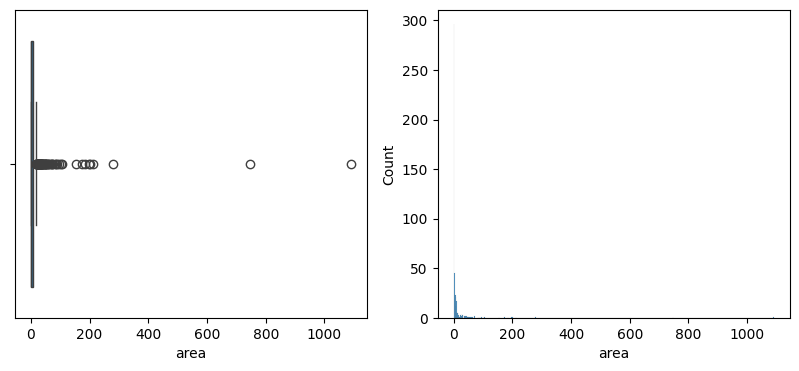

In [4]:

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['area'], kde = False)

Un modo per riportare l'area su una scala migliore è l'utilizzo del logaritmo. Questa tecnica, oltre che ridurre questo sbilanciamento dei dati potrebbe avere, come effetto collaterale, la capacità predittiva del modello.

<Axes: xlabel='log_area', ylabel='Count'>

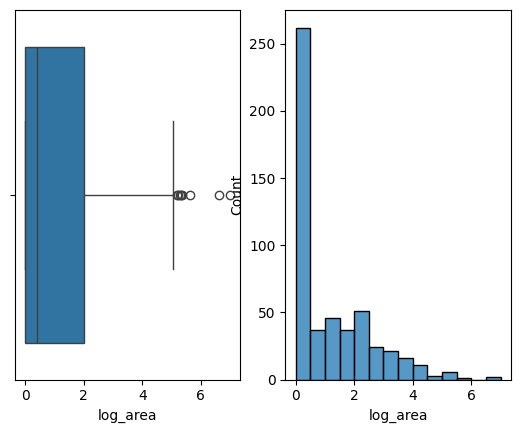

In [5]:
# Trasformazione logaritmica della variabile target
df['log_area'] = np.log(df['area'] + 1)
max_area = df['log_area'].max()


plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['log_area']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['log_area'], kde = False)

Ora diamo un'occhiata anche alla variabile 'rain'

<Axes: xlabel='rain', ylabel='Count'>

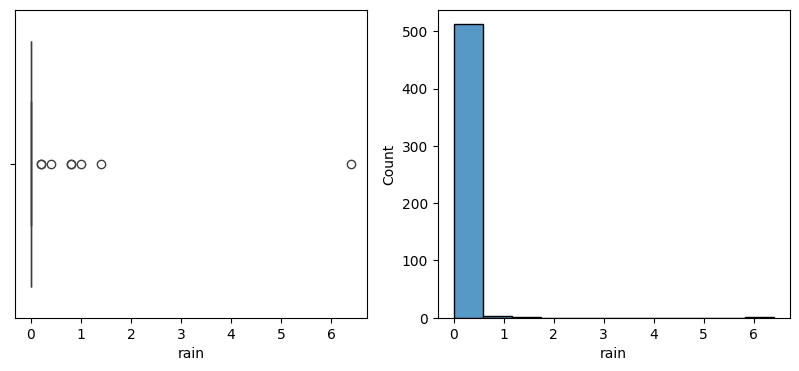

In [6]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = df['rain']) #for outliers
plt.subplot(1, 2, 2)
sns.histplot(data = df, x = df['rain'], kde = False)

Anche in questo caso i valori sono molto schiacciati verso lo zero... Si può provare anche qui un cambio di scala utilizzando il logaritmo ma non sarebbe opportuno, perchè i valori della pioggia sono fondamentali nell'apprendimento perchè sono una parte fondamentale nella previsione di incendi e il logaritmo ne riduce l'importanza (coerentemente a quanto detto non è opportuno rimuovore gli outliers) 

Ora riproponiamo dati per fare ulteriori analisi sulle variabili stringa

In [7]:
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00,0.000000
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00,0.000000
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00,0.000000
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00,0.000000
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,2.006871
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,4.012592
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,2.498152
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0.000000


Chiaramente i mesi e i giorni non sono caratteristiche numerice, quindi vanno codificate. Qui è possibile fare due considerazioni distinte: per i MESI possiamo adottare una codifica ciclica dato che sono essi stessi dei cicli, ma soprattutto generalmente esistono dei mesi piu caldi e piu freddi e questa relazione non è indipendente dai mesi; mentre pwr quanto riguarda i GIORNI si può pensare di utilizzare OneHotEncoding per non aggiungere ulteriori relazioni d'ordine al modello (in qaunto idealmente non necessarie per i giorni).

In [8]:
# CODIFICA MESI
enc = preprocessing.OrdinalEncoder(categories=[['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']])

months = df['month'].unique()

# Applica la codifica alla colonna 'month'
df['month_encoded'] = enc.fit_transform(df[['month']])
df['month_encoded'] = df['month_encoded'] + 1

# Applica la codifica ciclica
df['month_encoded_sin'] = np.sin(2 * np.pi * df['month_encoded'] / len(months))  # Codifica seno


# CODIFICA GIORNI
enc_oneHot = preprocessing.OneHotEncoder()

arr = enc_oneHot.fit_transform(df[['day']]) 

# Conversione in array denso
dense_array = arr.toarray()
# Recuero nomi per le colonne
col_names = enc_oneHot.get_feature_names_out(['day'])
# Creazione DataFrame dalle colonne codificate da concatenare a quello originale
encoded_df = pd.DataFrame(dense_array, columns=col_names, index=df.index)

df = pd.concat([df, encoded_df], axis=1)

df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,month_encoded,month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292,1.111026,7.475822,-0.541053,0.164410,0.143133,0.162476,0.183752,0.117988,0.123791,0.104449
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818,1.398436,2.275990,0.702852,0.371006,0.350548,0.369244,0.387657,0.322907,0.329662,0.306138
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,7.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000,0.418710,8.000000,-0.866025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000,2.024193,9.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000,6.995620,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Un ulteriore passo è la pulizia del DataFrame per rimuovore le colonne che non verranno utilizzate durante l'addestramento

In [9]:
df.drop(columns=['day', 'month', 'area', 'month_encoded'], inplace=True)
df

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,month_encoded_sin,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000,-0.866025,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152,-0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000,-0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Prima di cercare un modello opportuno e addestrarlo analizzaimo le correlazioni tra le colonne del dataset. Le colonne sottoposte a oneHotEncoding, semplicemente, non verranno considerate, al fine di evitare eventuali correlazioni dovute dalla natura della codifica

<Axes: title={'center': 'Features Correlation'}>

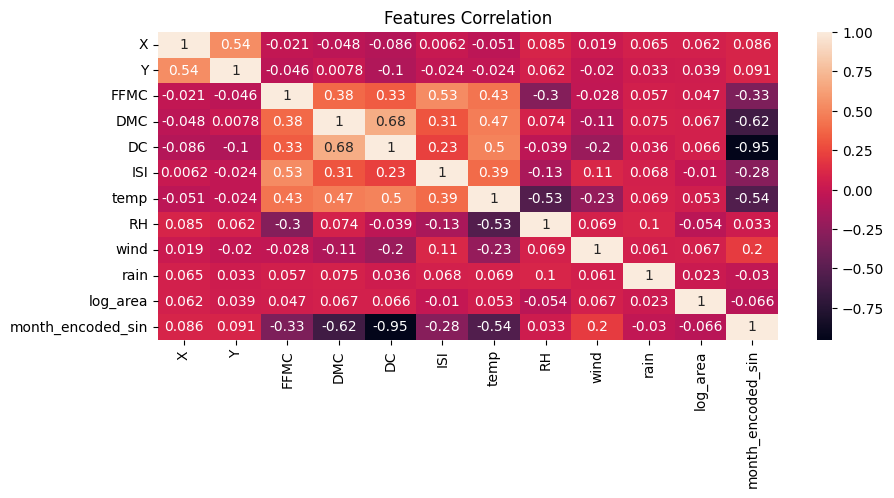

In [10]:
#df without theese two features (species and target)
df_corr = df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'])

plt.figure(figsize=(10,4))
plt.title('Features Correlation')

sns.heatmap(df_corr.corr(), annot=True) # Usa la correlazione di Pearson

Si può notare come il DC è molto correlato ai mesi dell'anno... c'era da aspettarselo vista la natura della caratteristica DC (vedere README).
Prima di effettuare ulteriori manipolazioni del dataset, però, proviamo ad addestrare qualche modello (verrà utilizzato l'argomento random state = 42 per la riproducibilità dei risultati nel confronto tra modelli).

In [11]:
df.drop(columns=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'], inplace=True)

- Dopo vari test si è notato come l'accuratezzza dei modelli migliora rimuovendo i giorni dalle caratteristiche del dataset . Questo potrebbe esser dovuto dal fatto che i giorni non racchiudono informazioni necessarie per il task in questione, aggiungono solo rumore e aumento di complessità computazionale a causa dei calcoli sulla matrice sparsa. 

Come prima cosa si può provare ad effettuareuna regressione lineare, provando a vedere se esiste una relazione lineare tra le caratteristiche e l'output

- LINEAR REGRESSOR:

Mean Absolute Error: 1.1865045061594848 -> km^2 = 0.022756112934549187
Train error (MAE): 1.1240844078310506
------------
Mean Squared Error: 2.1844052584845253
Root Mean Squared Error: 1.477973361899505 -> km^2 = 0.033840517852264676
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 78.87%
------------
Accuracy in percentage (with a tolerance of 5.0%): 8.65%
Accuracy in percentage (with a tolerance of 10.0%): 17.31%
Accuracy in percentage (with a tolerance of 25.0%): 77.88%
Accuracy in percentage (with a tolerance of 50.0%): 94.23%


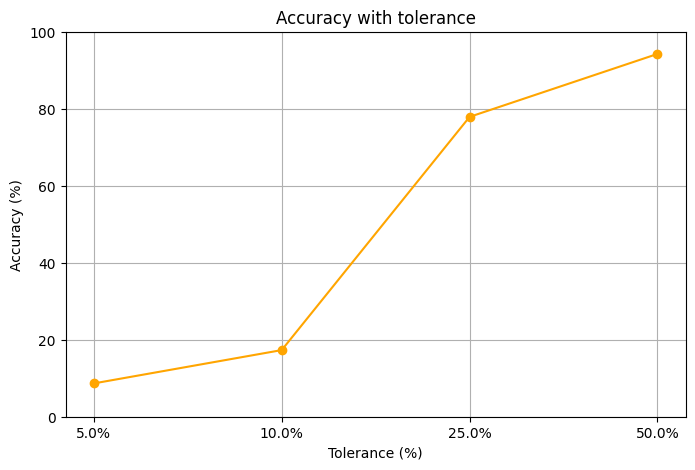

In [12]:
# LINEAR REGRESSOR

X = df.drop(['log_area'], axis=1)  # Features
y = df['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = LinearRegression()
model.fit(X_train, y_train)

# Predizioni
y_pred = model.predict(X_test)

# Predizioni  sui dati di addestramento
y_train_pred = model.predict(X_train)

# Valutazione performace
print('- LINEAR REGRESSOR:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

L'accuratezza del linear regressor non è buona... Un approccio con support vector machines potrebbe essere una scelta opportuna per cercare relazioni non lineari tra le caratteristiche e la variabile di output. Questo approccio, tramite una funzione kernel, trasforma e mappa i dati in un nuovo spazio al fine di trovare pattern rilevanti nei dati (funzione kernel utilizzata: rbf)

Best parameters: {'C': 1, 'gamma': 0.1}
- SVM:

Mean Absolute Error: 1.0863498908523048 -> km^2 = 0.01963437437045906
Train error (MAE): 0.878988975927549
------------
Mean Squared Error: 2.485849786629047
Root Mean Squared Error: 1.5766577899560346 -> km^2 = 0.03838756614799872
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 77.46%
------------
Accuracy in percentage (with a tolerance of 5.0%): 26.92%
Accuracy in percentage (with a tolerance of 10.0%): 49.04%
Accuracy in percentage (with a tolerance of 25.0%): 76.92%
Accuracy in percentage (with a tolerance of 50.0%): 92.31%


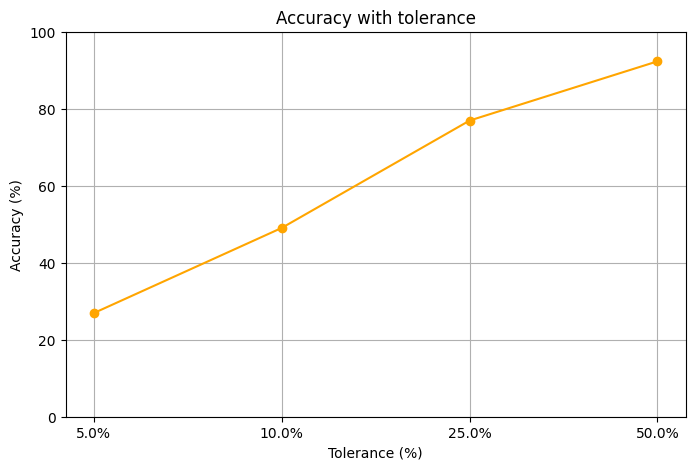

In [13]:
# SVM

X = df.drop(['log_area'], axis=1)  # Features
y = df['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = SVR(kernel='rbf')
#model.fit(X_train, y_train)

# Parametri da esplorare con GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Penalità dell'errore
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]  # Flessibilità del kernel RBF
}
# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)


# Valutazione performace
print('- SVM:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Proviamo ora con una rete neurale

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best parameters found:  {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'sgd'}
- NN:

Mean Absolute Error: 1.1584902335716707 -> km^2 = 0.0218512085567682
Train error (MAE): 1.092942410604033
------------
Mean Squared Error: 2.2002249629685044
Root Mean Squared Error: 1.4833155304818002 -> km^2 = 0.03407534798195721
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 78.80%
------------
Accuracy in percentage (with a tolerance of 5.0%): 9.62%
Accuracy in percentage (with a tolerance of 10.0%): 22.12%
Accuracy in percentage (with a tolerance of 25.0%): 77.88%
Accuracy in percentage (with a tolerance of 50.0%): 93.27%


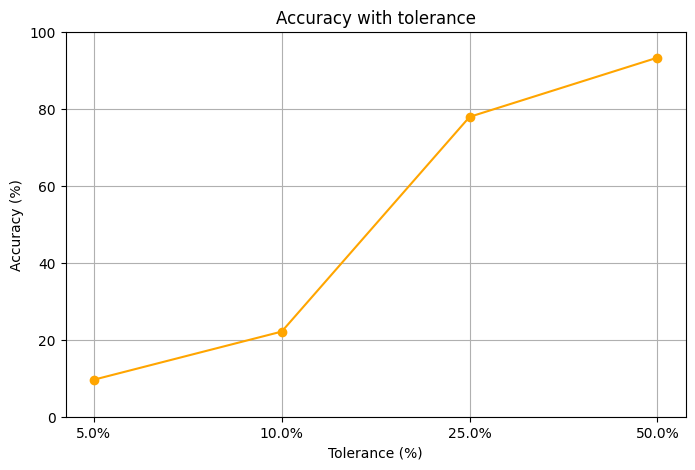

In [14]:
# NN 
X = df.drop(['log_area'], axis=1)  # Features
y = df['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modello
model = MLPRegressor(max_iter=1000, random_state=42)

# Parametri da ottimizzare
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],  # Diversi layer e dimensioni
    'activation': ['relu', 'tanh'],  # Funzioni di attivazione
    'solver': ['adam', 'sgd'],  # Algoritmi di ottimizzazione
    'alpha': [0.00001, 0.0001, 0.001, 0.01],  # Penalizzazione L2
    'learning_rate': ['constant', 'adaptive'],  # Velocità di apprendimento
}

# Definizione di un custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=mae_scorer, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- NN:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
- GRADIENT BOOST REGRESSION:

Mean Absolute Error: 1.1926384725992896 -> km^2 = 0.022957655327196392
Train error (MAE): 1.0591770392159643
------------
Mean Squared Error: 2.136318299532505
Root Mean Squared Error: 1.4616149628176722 -> km^2 = 0.03312919111098962
51 / 104 of y_test is 0
------------
Precisione del modello rispetto all'area massima: 79.11%
------------
Accuracy in percentage (with a tolerance of 5.0%): 12.50%
Accuracy in percentage (with a tolerance of 10.0%): 18.27%
Accuracy in percentage (with a tolerance of 25.0%): 81.73%
Accuracy in percentage (with a tolerance of 50.0%): 94.23%


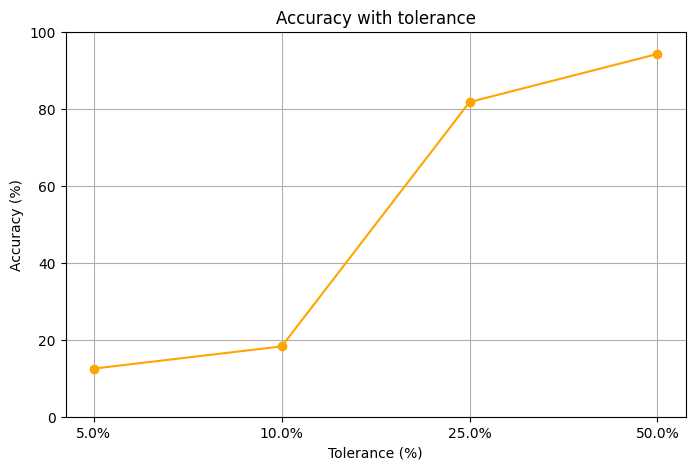

In [15]:
# GRADIENT BOOST REGRESSION
X = df.drop(['log_area'], axis=1)
#X = df[['temp', 'RH', 'wind', 'rain']]
y = df['log_area']  # Target

# Normalizzare variabili numeriche
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisione del dataset in training e testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Parametri da esplorare
param_grid = {
    'n_estimators': [100, 200, 300, 500],        # Numero di alberi
    'learning_rate': [0.01, 0.1, 0.2],     # Velocità di apprendimento
    'max_depth': [3, 5, 7, 10],                # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],       # Minimo numero di campioni per split
    'min_samples_leaf': [1, 2, 4],         # Minimo numero di campioni in una foglia
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Grid Search con validazione incrociata
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit dei dati di addestramento
grid_search.fit(X_train, y_train)

# Miglior modello
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Predizioni
y_pred = best_model.predict(X_test)

# Predizioni sui dati di addestramento
y_train_pred = best_model.predict(X_train)

# Valutazione performace
print('- GRADIENT BOOST REGRESSION:\n')
evaluation.evaluate(y_test, y_pred, y_train, y_train_pred, max_area)